In [3]:
import os
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

# PenSimEnv

In [8]:
from pensimpy.examples.recipe import Recipe, RecipeCombo
from pensimpy.data.constants import FS, FOIL, FG, PRES, DISCHARGE, WATER, PAA
from pensimpy.data.constants import FS_DEFAULT_PROFILE, FOIL_DEFAULT_PROFILE, FG_DEFAULT_PROFILE, \
    PRESS_DEFAULT_PROFILE, DISCHARGE_DEFAULT_PROFILE, WATER_DEFAULT_PROFILE, PAA_DEFAULT_PROFILE
from quarticgym.envs.pensimenv import PenSimEnvGym, PeniControlData, NUM_STEPS

In [9]:
# set up the default recipe
recipe_dict = {FS: Recipe(FS_DEFAULT_PROFILE, FS),
            FOIL: Recipe(FOIL_DEFAULT_PROFILE, FOIL),
            FG: Recipe(FG_DEFAULT_PROFILE, FG),
            PRES: Recipe(PRESS_DEFAULT_PROFILE, PRES),
            DISCHARGE: Recipe(DISCHARGE_DEFAULT_PROFILE, DISCHARGE),
            WATER: Recipe(WATER_DEFAULT_PROFILE, WATER),
            PAA: Recipe(PAA_DEFAULT_PROFILE, PAA)}

recipe_combo = RecipeCombo(recipe_dict=recipe_dict)
# set up the environment
env = PenSimEnvGym(recipe_combo=recipe_combo)
state = env.reset()
# load one batch of the sampled data
load_just_a_file='quarticgym/datasets/pensimenv/random_batch_0.csv'
dataset_obj = PeniControlData(load_just_a_file=load_just_a_file)
if dataset_obj.file_list:
    print('Penicillin_Control_Challenge data correctly initialized.')
else:
    raise ValueError("Penicillin_Control_Challenge data initialization failed.")
dataset = dataset_obj.get_dataset()
# need to be set by dataset for normalization
env.max_observations = dataset_obj.max_observations
env.min_observations = dataset_obj.min_observations
env.normalize = True
# now, let's try to run for one epoch, use the actions cloned from a csv file. Note that the environment setup might be different.
total_reward = 0.0
for step in range(NUM_STEPS):
    state, reward, done, info = env.step(dataset['actions'][step].tolist())
    total_reward += reward
    if step%1000 == 0:
        print("reward, total_reward:",reward, total_reward)
print("your total reward is (by default, should be around 2965):", total_reward)

Penicillin_Control_Challenge data correctly initialized.
reward, total_reward: 0.05834041883349912 0.05834041883349912
reward, total_reward: 2.7455784447631686 2586.295427653821
your total reward is (by default, should be around 2965): 2965.6087902382847


# BeerFMTEnv

In [4]:
from quarticgym.envs.beerfmtenv import BeerFMTEnvGym, MAX_LENGTH
from quarticgym.envs.utils import normalize_spaces
# initialize the default policy
profile_cons = [13] * 200 # constant actions
profile_industrial = [11 + 1 / 8 * i for i in range(25)] \
                          + [14] * 95 \
                          + [14 + 2 / 25 * i for i in range(25)] \
                          + [16] * 25 + [16 - 8 / 15 * i for i in range(14)] + [9]*16 # a simple policy

In [5]:
profile_inuse = profile_cons
env = BeerFMTEnvGym()
state = env.reset()
total_reward = 0.0
for step in tqdm(range(MAX_LENGTH)):
    action = np.array([profile_inuse[step]], dtype=np.float32)
    action = normalize_spaces(action, env.max_actions, env.min_actions) # need to normalize the action before passes in
    state, reward, done, info = env.step(action)
    total_reward += reward
    if done:
        break
res_cons = info["res_forplot"]
print("your end at step", step, "and total reward is:", total_reward)
#your end at step 188 and total reward is: 12.0

 94%|█████████▍| 188/200 [00:00<00:00, 2059.02it/s]

your end at step 188 and total reward is: 12.0


In [6]:
profile_inuse = profile_industrial
env = BeerFMTEnvGym()
state = env.reset()
total_reward = 0.0
for step in tqdm(range(MAX_LENGTH)):
    action = np.array([profile_inuse[step]], dtype=np.float32)
    action = normalize_spaces(action, env.max_actions, env.min_actions) # need to normalize the action before passes in
    state, reward, done, info = env.step(action)
    total_reward += reward
    if done:
        break
res_industrial = info["res_forplot"]
print("your end at step", step, "and total reward is:", total_reward)
#your end at step 145 and total reward is: 55.0

 72%|███████▎  | 145/200 [00:00<00:00, 2095.54it/s]

your end at step 145 and total reward is: 55.0


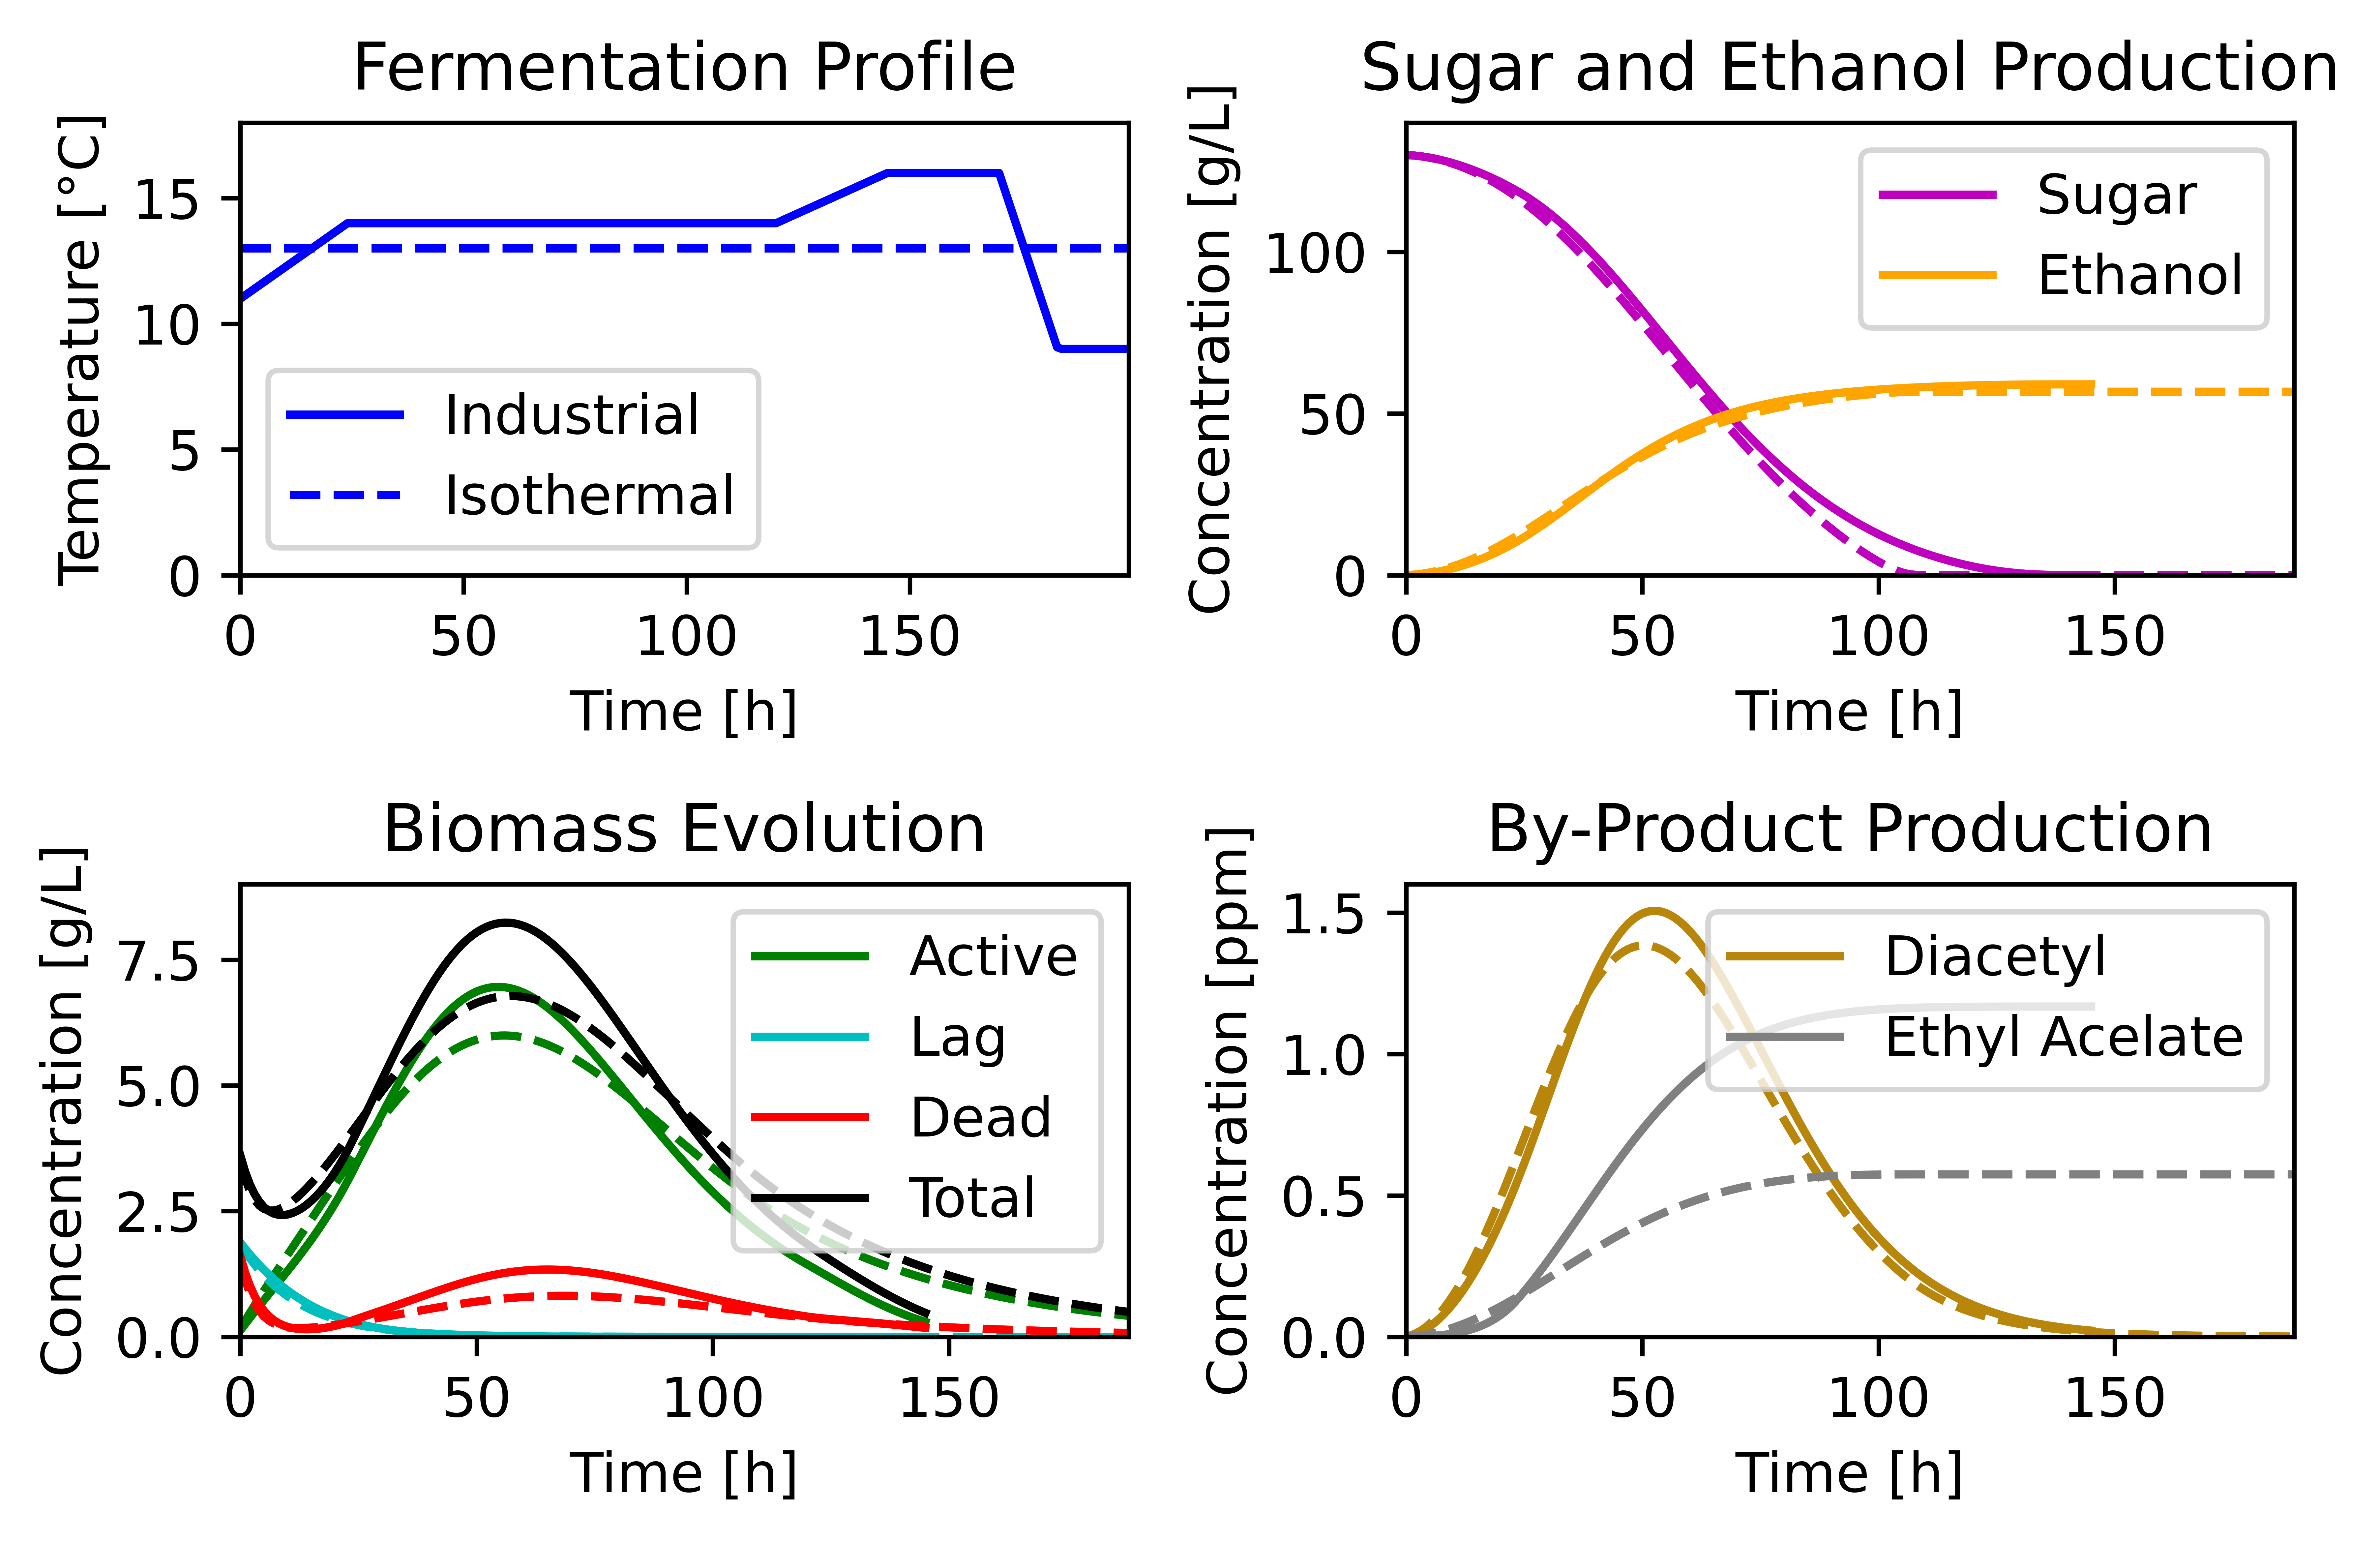

In [7]:
# plots
plt.figure(dpi=1200)
plt.subplot(2, 2, 1)
plt.plot(profile_industrial, label='Industrial', color='blue')
plt.plot(profile_cons, label='Isothermal', color='blue', linestyle='dashed')
plt.autoscale(enable=True, axis='both', tight=True)
plt.ylim((0, 18))
plt.xlabel('Time [h]')
plt.ylabel('Temperature [\u00B0C]')
plt.title("Fermentation Profile")
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(res_industrial[:, 3], label='Sugar', color='m')
plt.plot(res_cons[:, 3], color='m', linestyle='dashed')
plt.plot(res_industrial[:, 4], label='Ethanol', color='orange')
plt.plot(res_cons[:, 4], color='orange', linestyle='dashed')
plt.autoscale(enable=True, axis='both', tight=True)
plt.ylim((0, 140))
plt.xlabel('Time [h]')
plt.ylabel('Concentration [g/L]')
plt.title("Sugar and Ethanol Production")
plt.legend()

plt.subplot(2, 2, 3)
plt.plot(res_industrial[:, 0], label='Active', color='green')
plt.plot(res_cons[:, 0], color='green', linestyle='dashed')
plt.plot(res_industrial[:, 1], label='Lag', color='c')
plt.plot(res_cons[:, 1], color='c', linestyle='dashed')
plt.plot(res_industrial[:, 2], label='Dead', color='red')
plt.plot(res_cons[:, 2], color='red', linestyle='dashed')
plt.plot(res_industrial[:, 0] + res_industrial[:, 1] + res_industrial[:, 2], label='Total', color='black')
plt.plot(res_cons[:, 0] + res_cons[:, 1] + res_cons[:, 2], color='black', linestyle='dashed')
plt.autoscale(enable=True, axis='both', tight=True)
plt.ylim((0, 9))
plt.xlabel('Time [h]')
plt.ylabel('Concentration [g/L]')
plt.title("Biomass Evolution")
plt.legend()

plt.subplot(2, 2, 4)
plt.plot(res_industrial[:, 5], label='Diacetyl', color='darkgoldenrod')
plt.plot(res_cons[:, 5], color='darkgoldenrod', linestyle='dashed')
plt.plot(res_industrial[:, 6], label='Ethyl Acelate', color='grey')
plt.plot(res_cons[:, 6], color='grey', linestyle='dashed')
plt.autoscale(enable=True, axis='both', tight=True)
plt.ylim((0, 1.6))
plt.xlabel('Time [h]')
plt.ylabel('Concentration [ppm]')
plt.title("By-Product Production")
plt.legend()


plt.tight_layout()
plt.show()

# AtropineEnv

In [1]:
import numpy as np
from quarticgym.envs.atropineenv import AtropineEnvGym
env = AtropineEnvGym()
init_state = env.reset()
print("init_state.shape", init_state.shape)
state, reward, done, info = env.step(np.ones(4)*0.5)
print("state.shape", init_state.shape)
print("reward", reward) # should be -5.329070518200751e-15

init_state.shape (1724,)
state.shape (1724,)
reward -5.329070518200751e-15


In [ ]:
# or, if we want to run a full loop to see the plot:
env = AtropineEnvGym(uss_observable=True, reward_on_steady=False, reward_on_absolute_efactor=False, observation_include_t=True, observation_include_action=True, observation_include_uss=True, observation_include_ess=True, observation_include_e=True, observation_include_kf=True, observation_include_z=True, observation_include_x=True)
init_state = env.reset()
for i in range(60):
    state, reward, done, info = env.step(np.ones(4)*0.5)
env.plot()

# ReactorEnv

In [1]:
from quarticgym.envs.reactorenv import ReactorEnvGym
env = ReactorEnvGym(normalize=False)
init_state = env.reset(initial_state=[0.8778252, 51.34660837, 0.659]) # init with steady state (setpoint)
state, reward, done, info = env.step([26.85, 0.1]) # feed in the steady action (setpoint action)
print("state", state) # should be [0.8778252, 51.34660837, 0.659], we still get the same steady state

state [ 0.8778252  51.34660727  0.65899998]


# MAbEnv

In [1]:
# upstream
from quarticgym.envs.mabenv import MAbUpstreamEnvGym, xscale, uscale
import numpy as np
env = MAbUpstreamEnvGym(normalize=False, init_mpc_controllers=False, standard_reward_style='setpoint')
xss = env.xss / xscale
uss = env.uss / uscale
env.reset(xss)
observation, reward, done, info = env.step(uss, normalize=False)
assert (np.square(observation - xss)).sum() < 1e-10 # it is steady, so given steady action at steady state, we should still get steady state
env = MAbUpstreamEnvGym(normalize=False, init_mpc_controllers=False, standard_reward_style='productivity')
env.reset(xss)
observation, reward, done, info = env.step(uss, normalize=False)
print(reward)

2282312.0873870137
